In https://arxiv.org/html/2401.06291v2, it sounds like the use an input of 96 channels for a rgb image, with a hidden size of 512. The 96 input channels they said was 3, for rgb input, 3 for rgb output, and 90 empty cahnels. I assume the output channels were also empty. Their code is not available.

I want to try this, where my model has an input channels + output channels input, with only an output channels output. 
Idea is to reuse the initial input when the NCA is applied multiple times, like a residual, and continuously updating the output.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from IPython.display import display, clear_output
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel, DDPMScheduler
from diffusers.models.embeddings import TimestepEmbedding

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


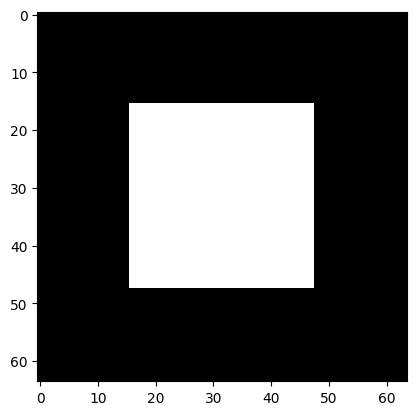

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


image_size = 64  # 64x64 pixels
# Create a single-channel image: all zeros with a white square in the middle.
image = torch.zeros((1, 1, image_size, image_size), device=device)
image[:, :, 16:48, 16:48] = 1.0

plt.imshow(image[0, 0].cpu().numpy(), cmap='gray')

In [31]:
class NCAD_LargerLayers(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(NCAD_LargerLayers, self).__init__()

        self.inchannels = in_channels
        self.outchannels = out_channels
        self.hiddenInputLayers = 3
        channelWidth = 32
        self.channelWidth = channelWidth

        timestepEmbedSize = 16
        self.timestepEmbedding = TimestepEmbedding(in_channels=1, time_embed_dim=timestepEmbedSize)
        self.timeLin = nn.Linear(timestepEmbedSize, channelWidth)
        
        self.conv1 = nn.Conv2d(in_channels + out_channels + self.hiddenInputLayers, channelWidth, kernel_size=3, padding=1)  # 3x3 convolution
        self.conv2 = nn.Conv2d(channelWidth, channelWidth, kernel_size=1)
        self.conv3 = nn.Conv2d(channelWidth, channelWidth, kernel_size=1) # 1x1 convolution
        self.conv4 = nn.Conv2d(channelWidth, out_channels + self.hiddenInputLayers, kernel_size=1) # 1x1 convolution

    def forward(self, inp, t):
        bs, ch, height, width = inp.shape

        timeEmbedding = self.timestepEmbedding(t) 
        timeModifier = F.sigmoid(self.timeLin(timeEmbedding)) # shape 32
        timeModifier = timeModifier.view(1, self.channelWidth, 1, 1)
        timeModifier = timeModifier.repeat(1, 1, height, width)

        x = F.relu(self.conv1(inp)) # shape (1, 32, 64)
        x = x + timeModifier 
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = F.sigmoid(x)

        # This multiplicative approach did not work
        # x_clone = x.clone() # Likely expensive
        # x_clone[:, :1, :, :] = x[:, :1, :, :] * self.timeLin(timeEmbedding) + inp[:, :1, :, :] * (1 - self.timeLin(timeEmbedding))
        return x
    
    def infer(self, x, steps, t):
        output = torch.zeros_like(x, device=x.device)
        hidden = torch.zeros((x.size(0), self.hiddenInputLayers, x.size(2), x.size(3)), dtype=x.dtype, device=x.device)

        concattedOutput = torch.cat((output, hidden), dim=1)

        for i in range(steps):
            concattedOutput = self.forward(
                torch.cat((x, concattedOutput), dim=1),
                t)
            
        return concattedOutput[:, :1, :, :] # First 1 channel
    
model = NCAD_LargerLayers(1, 1).to(device)

Op = torch.optim.Adam(model.parameters(), lr=1e-4)

diffusionSteps = 100 # ~timesteps
scheduler = DDPMScheduler(num_train_timesteps=diffusionSteps, beta_schedule='squaredcos_cap_v2')

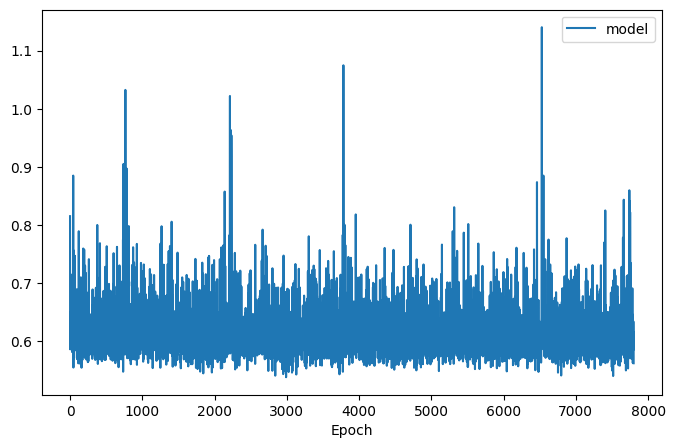

KeyboardInterrupt: 

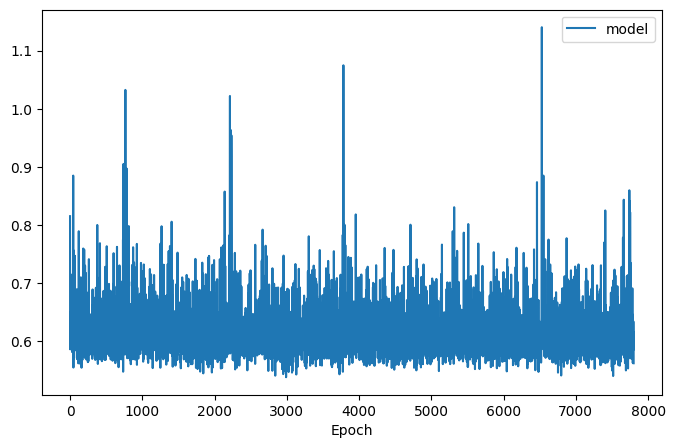

In [35]:
model.train()

epochs = 10001
losses = {
    'model': [],
}

fig, ax = plt.subplots(figsize=(8, 5))
display(fig)

highloss = []


for epoch in range(epochs):
    Op.zero_grad()
    
    #Should try batch training
    t = torch.randint(0, diffusionSteps, (image.shape[0],), device=device).float()
    noise = torch.randn_like(image, device=device)
    noisyImage = scheduler.add_noise(image, noise, t.long())

    Pred = model.infer(noisyImage, 10, t)

    Loss = F.mse_loss(Pred, noise)
    Loss.backward()
    Op.step()

    # if TimeLoss.item() > 0.7:
    #     highloss.append((t, TimeLoss.item()))

    losses['model'].append(Loss.item())
    if epoch % 100 == 0:
        clear_output(wait=True)  
        ax.clear()
        plt.plot(losses["model"][1000:], label=f'model')
        plt.legend()
        plt.xlabel('Epoch')
        display(fig)
    
clear_output(wait=True)  
ax.clear()
plt.plot(losses["model"][1000:], label=f'model')
plt.legend()
plt.xlabel('Epoch')
display(fig)

In [33]:
highloss

[]

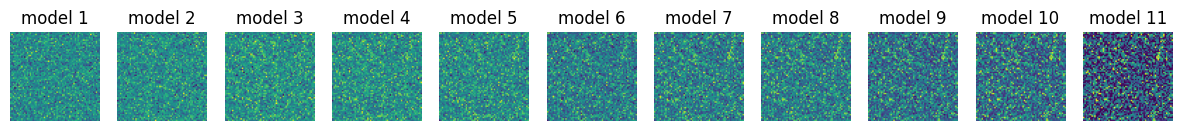

In [34]:
# Inference of trained models 

model.eval()

inferenceSteps = 100
scheduler.set_timesteps(inferenceSteps)

with torch.no_grad():
    singleX = torch.randn_like(image).to(device)
    intermediateImages = {
        'model': [],
        'model': [],
    }

    for i, t in enumerate(scheduler.timesteps):
        timeTensor = torch.tensor([t]).float().to(device)
        singleOut = model.infer(singleX, 10, timeTensor)

        singleX = scheduler.step(singleOut, t, singleX).prev_sample

        if i % 10  == 0:
            intermediateImages['model'].append(singleX.cpu().numpy())
    
    #Might be a duplicate from last step
    intermediateImages['model'].append(singleX.cpu().numpy())

numColumns = len(intermediateImages['model'])
fig, axs = plt.subplots(1, numColumns, figsize=(15, 3))

# Plot images
for row, key in enumerate(['model']):
    for col, img in enumerate(intermediateImages[key]):
        axs[ col].imshow(img[0,0])
        axs[ col].axis('off')  
        axs[ col].set_title(f"{key} {col+1}")  


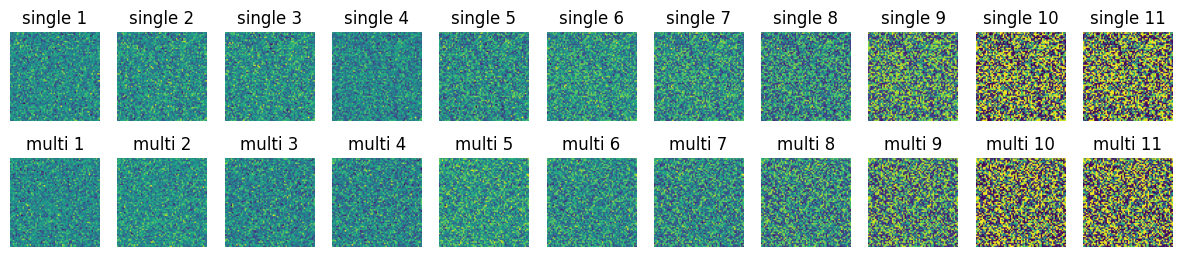

In [8]:
# Inference of trained models 

singleStepModel.eval()
multiStepModel.eval()

inferenceSteps = 20
scheduler.set_timesteps(inferenceSteps)

with torch.no_grad():
    singleX = torch.randn_like(image).to(device)
    multiX = singleX.clone()
    intermediateImages = {
        'single': [],
        'multi': [],
    }

    for i, t in enumerate(scheduler.timesteps):
        timeTensor = torch.tensor([t]).float().to(device)
        singleOut = singleStepModel.infer(singleX, 1, timeTensor)
        multiOut = multiStepModel.infer(multiX, 20, timeTensor)

        singleX = scheduler.step(singleOut, t, singleX).prev_sample
        multiX = scheduler.step(multiOut, t, multiX).prev_sample

        if i % 2:
            intermediateImages['single'].append(singleX.cpu().numpy())
            intermediateImages['multi'].append(multiX.cpu().numpy())
    
    #Might be a duplicate from last step
    intermediateImages['single'].append(singleX.cpu().numpy())
    intermediateImages['multi'].append(multiX.cpu().numpy())

numColumns = len(intermediateImages['single'])
fig, axs = plt.subplots(2, numColumns, figsize=(15, 3))

# Plot images
for row, key in enumerate(['single', 'multi']):
    for col, img in enumerate(intermediateImages[key]):
        axs[row, col].imshow(img[0,0])
        axs[row, col].axis('off')  
        axs[row, col].set_title(f"{key} {col+1}")  
